# Лабораторная работа №2. 
## Реализация глубокой нейронной сети


### <a href="http://yaroslavvb.blogspot.sg/2011/09/notmnist-dataset.html">Данные</a>
<a href="https://commondatastorage.googleapis.com/books1000/notMNIST_large.tar.gz">BIG</a>
<a href="https://commondatastorage.googleapis.com/books1000/notMNIST_small.tar.gz">SMALL</a>

В работе предлагается использовать набор данных notMNIST, который состоит из изображений размерностью 28×28 первых 10 букв латинского алфавита (A … J, соответственно). Обучающая выборка содержит порядка 500 тыс. изображений, а тестовая – около 19 тыс.



### Задания
- [x] Реализуйте полносвязную нейронную сеть с помощью библиотеки Tensor Flow. В качестве алгоритма оптимизации можно использовать, например, стохастический градиент (Stochastic Gradient Descent, SGD). Определите количество скрытых слоев от 1 до 5, количество нейронов в каждом из слоев до нескольких сотен, а также их функции активации (кусочно-линейная, сигмоидная, гиперболический тангенс и т.д.).
- [x] Как улучшилась точность классификатора по сравнению с логистической регрессией?
- [x] Используйте регуляризацию и метод сброса нейронов (dropout) для борьбы с переобучением. Как улучшилось качество классификации?
- [ ] Воспользуйтесь динамически изменяемой скоростью обучения (learning rate). Наилучшая точность, достигнутая с помощью данной модели составляет 97.1%. Какую точность демонстрирует Ваша реализованная модель?

In [2]:
%%time

import numpy as np
import pandas as pd

from common import Dataset

# Initial data
dataset = {
    'small': 'https://commondatastorage.googleapis.com/books1000/notMNIST_small.tar.gz',
    'large': 'https://commondatastorage.googleapis.com/books1000/notMNIST_large.tar.gz',
}

# Create Datasets
ds_small = Dataset.load(name='notMNIST_small', url=dataset['small'])
ds_large = Dataset.load(name='notMNIST_large', url=dataset['large'])

CPU times: user 3min 14s, sys: 1min 26s, total: 4min 40s
Wall time: 7min 12s


In [4]:
%%time

import numpy as np
import tensorflow as tf

from sklearn.preprocessing import scale, LabelEncoder

# Get train X, Y 
X_train = ds_large.X
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
X_train = scale(X_train)

Y_train = LabelEncoder().fit_transform(ds_large.Y.flatten())

# Get test X, Y
X_test = ds_small.X
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])
X_test = scale(X_test)

Y_test = LabelEncoder().fit_transform(ds_small.Y.flatten())

CPU times: user 15.8 s, sys: 14.5 s, total: 30.3 s
Wall time: 1min 1s


In [6]:
%%time

import tensorflow as tf

# Without dropouts
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(800, activation='relu'),
    tf.keras.layers.Dense(400, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer='SGD', 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])
history = model.fit(
    X_train, Y_train, 
    epochs=10, 
    validation_data=(X_test, Y_test)
)

Train on 529114 samples, validate on 18724 samples
Epoch 1/10
529114/529114 [==============================] - 115s 217us/sample - loss: 0.4248 - accuracy: 0.8732 - val_loss: 0.1805 - val_accuracy: 0.9468
Epoch 2/10
529114/529114 [==============================] - 115s 217us/sample - loss: 0.3161 - accuracy: 0.9046 - val_loss: 0.1537 - val_accuracy: 0.9552
Epoch 3/10
529114/529114 [==============================] - 103s 194us/sample - loss: 0.2749 - accuracy: 0.9163 - val_loss: 0.1353 - val_accuracy: 0.9600
Epoch 4/10
529114/529114 [==============================] - 112s 211us/sample - loss: 0.2465 - accuracy: 0.9246 - val_loss: 0.1281 - val_accuracy: 0.9620
Epoch 5/10
529114/529114 [==============================] - 110s 209us/sample - loss: 0.2238 - accuracy: 0.9314 - val_loss: 0.1226 - val_accuracy: 0.9645
Epoch 6/10
529114/529114 [==============================] - 106s 201us/sample - loss: 0.2041 - accuracy: 0.9368 - val_loss: 0.1147 - val_accuracy: 0.9669
Epoch 7/10
529114/529114 

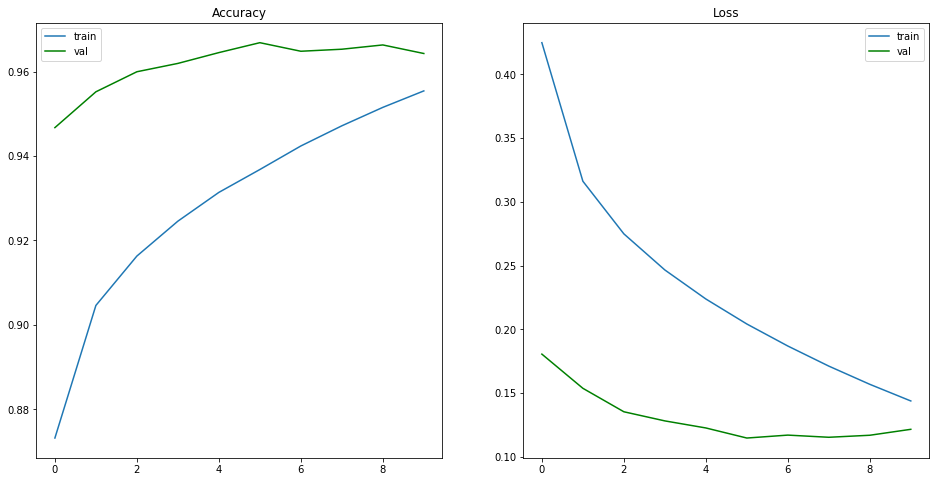

In [9]:
import matplotlib.pyplot as plt


def plot_history(history):
    _, ax = plt.subplots(1, 2, figsize= (16, 8))

    ax[0].set_title('Accuracy')
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'], color='green')
    ax[0].legend(['train', 'val'], loc='best')

    ax[1].set_title('Loss')
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'], color='green')
    ax[1].legend(['train', 'val'], loc='best')
    
plot_history(history)

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              multiple                  628000    
_________________________________________________________________
dense_5 (Dense)              multiple                  320400    
_________________________________________________________________
dense_6 (Dense)              multiple                  80200     
_________________________________________________________________
dense_7 (Dense)              multiple                  2010      
Total params: 1,030,610
Trainable params: 1,030,610
Non-trainable params: 0
_________________________________________________________________


In [24]:
%%time

import tensorflow as tf

# Add dropouts
model_with_dropouts = tf.keras.models.Sequential([
    tf.keras.layers.Dense(800, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(400, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation='softmax')
])

model_with_dropouts.compile(
    optimizer='SGD',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])
history = model_with_dropouts.fit(
    X_train, Y_train, 
    epochs=10, 
    validation_data=(X_test, Y_test)
)

Train on 529114 samples, validate on 18724 samples
Epoch 1/10
    32/529114 [..............................] - ETA: 3:15:34

KeyboardInterrupt: 

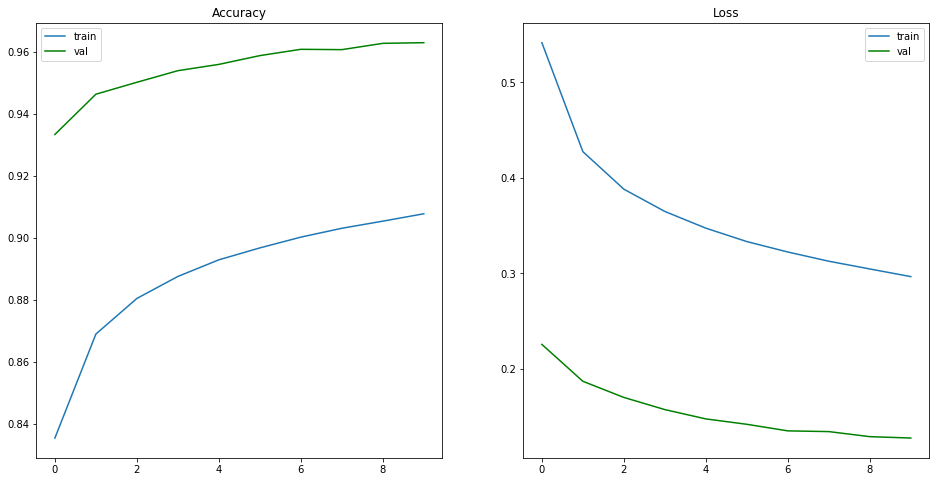

In [14]:
plot_history(history)

In [33]:
%%time

import tensorflow as tf

# Add dropouts
model_with_dropouts = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer='l2'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer='l2'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer='l2'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(10, activation='softmax')
])

model_with_dropouts.compile(
    optimizer='SGD',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

CPU times: user 5.22 ms, sys: 438 µs, total: 5.66 ms
Wall time: 5.33 ms


In [34]:
history = model_with_dropouts.fit(
    X_train, Y_train, 
    epochs=10, 
    validation_data=(X_test, Y_test)
)

Train on 529114 samples, validate on 18724 samples
Epoch 1/10
529114/529114 [==============================] - 84s 159us/sample - loss: 1.1812 - accuracy: 0.8075 - val_loss: 0.4929 - val_accuracy: 0.9109
Epoch 2/10
529114/529114 [==============================] - 83s 157us/sample - loss: 0.7331 - accuracy: 0.8356 - val_loss: 0.4543 - val_accuracy: 0.9150
Epoch 3/10
529114/529114 [==============================] - 82s 154us/sample - loss: 0.7057 - accuracy: 0.8401 - val_loss: 0.4380 - val_accuracy: 0.9184
Epoch 4/10
529114/529114 [==============================] - 87s 164us/sample - loss: 0.6922 - accuracy: 0.8418 - val_loss: 0.4317 - val_accuracy: 0.9205
Epoch 5/10
529114/529114 [==============================] - 86s 162us/sample - loss: 0.6817 - accuracy: 0.8437 - val_loss: 0.4189 - val_accuracy: 0.9222
Epoch 6/10
529114/529114 [==============================] - 85s 160us/sample - loss: 0.6749 - accuracy: 0.8451 - val_loss: 0.4200 - val_accuracy: 0.9214
Epoch 7/10
529114/529114 [=====

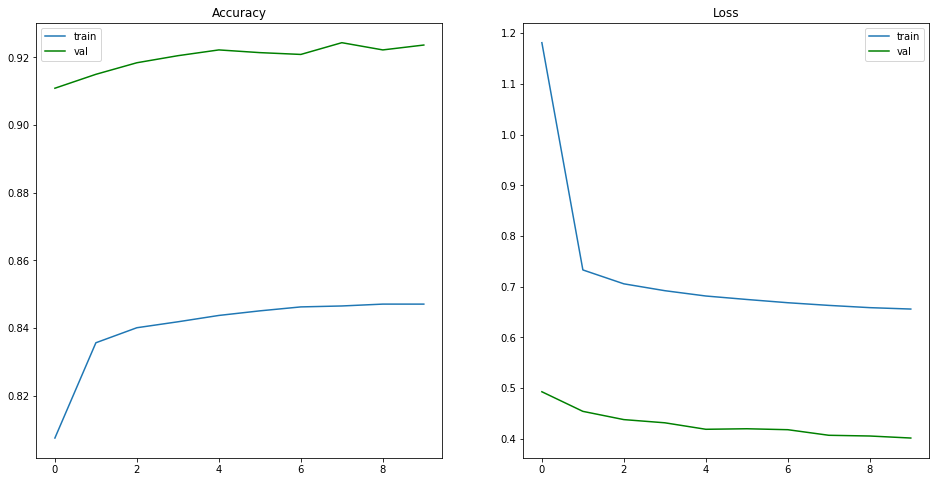

In [37]:
plot_history(history)

In [45]:
%%time

import tensorflow as tf

# Adam optimizer
model_adam = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer='l2'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer='l2'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer='l2'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(10, activation='softmax')
])


lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

model_adam.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

CPU times: user 5 ms, sys: 894 µs, total: 5.89 ms
Wall time: 5.53 ms


In [46]:
history = model_adam.fit(
    X_train, Y_train, 
    epochs=10,
    validation_data=(X_test, Y_test)
)

Train on 529114 samples, validate on 18724 samples
Epoch 1/10
529114/529114 [==============================] - 84s 159us/sample - loss: 1.1857 - accuracy: 0.8093 - val_loss: 0.4955 - val_accuracy: 0.9108
Epoch 2/10
529114/529114 [==============================] - 81s 153us/sample - loss: 0.7344 - accuracy: 0.8364 - val_loss: 0.4567 - val_accuracy: 0.9160
Epoch 3/10
529114/529114 [==============================] - 85s 161us/sample - loss: 0.7069 - accuracy: 0.8410 - val_loss: 0.4389 - val_accuracy: 0.9199
Epoch 4/10
529114/529114 [==============================] - 86s 162us/sample - loss: 0.6919 - accuracy: 0.8442 - val_loss: 0.4329 - val_accuracy: 0.9213
Epoch 5/10
529114/529114 [==============================] - 96s 182us/sample - loss: 0.6821 - accuracy: 0.8455 - val_loss: 0.4247 - val_accuracy: 0.9215
Epoch 6/10
529114/529114 [==============================] - 84s 159us/sample - loss: 0.6743 - accuracy: 0.8469 - val_loss: 0.4172 - val_accuracy: 0.9242
Epoch 7/10
529114/529114 [=====

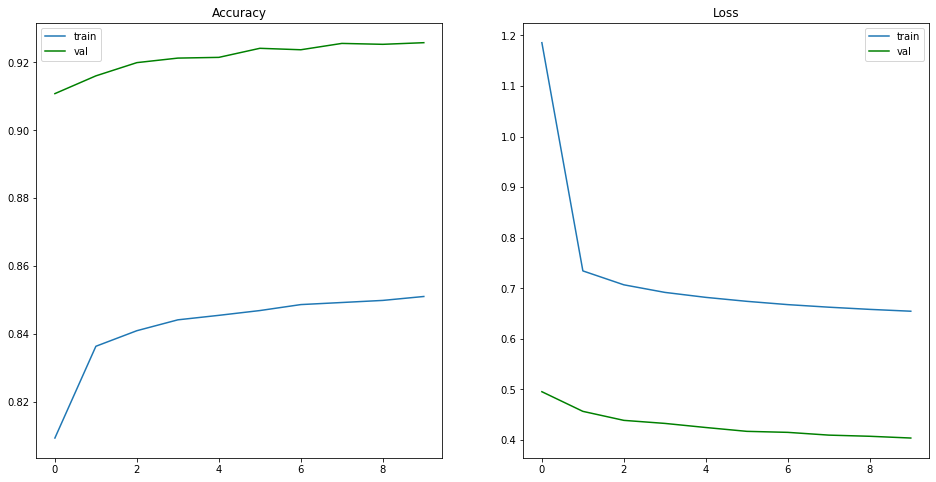

In [47]:
plot_history(history)